In [1]:
import pandas as pd

# Problem: they give you only an edited short sentence of the review, which doesn't give
# the general opinion about the review, so it's a bit weird

dataset = 'amz-clothing'
source_path = f'raw_data/CIKM20-NETE-Datasets/{dataset}/reviews.pickle'

df = pd.DataFrame(pd.read_pickle(source_path))

df.head(1)

,user,item,rating,template,predicted
0,A2M2APVYIB2U6K,0000031887,5,"(skirt, high, or high quality skirt, 1)",skirt


In [2]:
# Split weird template column into 4 columns

df[['feature', 'opinion', 'sentence', 'sentiment']] = pd.DataFrame(df['template'].tolist())
df = df.drop(['template', 'predicted'], axis=1)

df.head(1)

,user,item,rating,feature,opinion,sentence,sentiment
0,A2M2APVYIB2U6K,0000031887,5,skirt,high,or high quality skirt,1


In [3]:
# Only the sentence part is needed for my models. The sentries toolkit extracts more things,
# but I want to be able to use my model for datasets where sentries tookits has not been
# necessarily previously passed, as the creators already hint that it can take several days...

target_path = f'data/{dataset}/reviews.csv'

df = df[['user', 'item', 'rating', 'sentence']].rename(columns={'sentence': 'text'})
df.to_csv(target_path, index=False)

df.head(1)

,user,item,rating,text
0,A2M2APVYIB2U6K,0000031887,5,or high quality skirt


## Data origin check

In [ ]:
import gzip
import json
import pandas as pd

df1 = df

# Only for origin data purposes, I will not be using more columns?

def from_gzip(path):
    with gzip.open(path, 'rb') as f:
        data = [json.loads(line) for line in f]
    return pd.DataFrame(data)

df2 = from_gzip('raw_data/CIKM20-NETE-Datasets/amz-clothing/reviews_Clothing_Shoes_and_Jewelry_5.json.gz')

df2.head(1)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5.0,Great tutu- not cheaply made,1297468800,"02 12, 2011"


In [ ]:
# Only keeps els que estan en els 2 datasets, ja està bé pq l'interessant era el del PETER (df1)
df = pd.merge(df1, df2, left_on=['user', 'item'], right_on=['reviewerID', 'asin'])
df = df.drop(columns=['reviewerID', 'asin'])
print(df.shape, df1.shape, df2.shape)

df.head(1)

(179223, 14) (179223, 7) (278677, 9)


,user,item,rating,feature,opinion,sentence,sentiment,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2M2APVYIB2U6K,0000031887,5,skirt,high,or high quality skirt,1,Jamie P.,"[0, 0]",Great tutu for a great price. It isn't a &#34;...,5.0,Great value,1356220800,"12 23, 2012"


In [4]:
# la feature i la opinion són exactament una paraula
assert(df.apply(lambda row: len(row['feature'].split()) == 1, axis=1).all())
assert(df.apply(lambda row: len(row['opinion'].split()) == 1, axis=1).all())

# i estan tal qual en la sentence
assert(df.apply(lambda row: row['feature'] in row['sentence'], axis=1).all())
assert(df.apply(lambda row: row['opinion'] in row['sentence'], axis=1).all())

In [5]:
import re

def is_substring(long_string, short_string):
    long_string = re.sub(r'\W+', '', long_string).lower()
    short_string = re.sub(r'\W+', '', short_string).lower()
    return short_string in long_string

a = df.apply(lambda row: is_substring(row['summary']+'\n'+row['reviewText'], row['sentence']), axis=1)
assert(a.value_counts().get(False, 0) == 10) # Hi ha molts poc valors on no sigui així i són casos molt extrems
# on no val la penda invertir ni un segons més buscant

In [7]:
df.head(1)

,user,item,rating,feature,opinion,sentence,sentiment,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2M2APVYIB2U6K,0000031887,5,skirt,high,or high quality skirt,1,Jamie P.,"[0, 0]",Great tutu for a great price. It isn't a &#34;...,5.0,Great value,1356220800,"12 23, 2012"


## Weird things

In [23]:
df[(df['rating']==5) & (df['sentiment']==-1)].head(1) # frases negatives en reviews de rating 5

,user,item,rating,feature,opinion,sentence,sentiment,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
27,A3MHGA6BJJ7P27,1617160377,5,finish,less,that are clued into your number of finished le...,-1,"W. T. Hoffman ""artist and musician""","[9, 10]",ROSETTA STONE is famous for teaching language ...,5.0,The EXASPERATION of SPEACH RECOGNITION,1309305600,"06 29, 2011"


In [24]:
df[(df['rating']==1) & (df['sentiment']==1)].head(1) # frases positives en reviews de rating 1

,user,item,rating,feature,opinion,sentence,sentiment,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
18,A28QH3KX709FFQ,1608299953,1,product,little,i bought this product a little over a year ago,1,"Don Quixote ""Don Q""","[24, 31]",I bought this product a little over a year ago...,1.0,DO NOT BUY IF YOU EVER WANT TO RESELL IT.,1348185600,"09 21, 2012"


In [4]:
df['feature'].value_counts()

size          10843
fit            9409
look           8980
quality        6070
price          5326
              ...  
spillage          1
messenger         1
eyeglasses        1
fasciitis         1
downside          1
Name: feature, Length: 1162, dtype: int64

In [12]:
df['opinion'].value_counts()

great          19266
good           14071
nice           10562
perfect         8588
comfortable     7349
               ...  
unable             1
jagged             1
bearable           1
clad               1
recommended        1
Name: opinion, Length: 1161, dtype: int64

<Axes: ylabel='sentiment'>

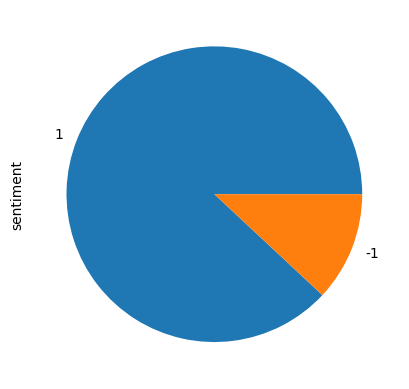

In [15]:
df['sentiment'].value_counts().plot(kind='pie')